In [1]:
from abc import ABC, abstractmethod
from copy import deepcopy
import faiss
import glob
from itertools import chain
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import keras.backend as K
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from style_stack import StyleStack
from utils import get_concatenated_images, get_concatenated_matrices, load_image, plot_results

from IPython.core.debugger import set_trace

/home/theaustinator/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Semantic Similarity Search

Classifiers

### Dataset Labeled by Style

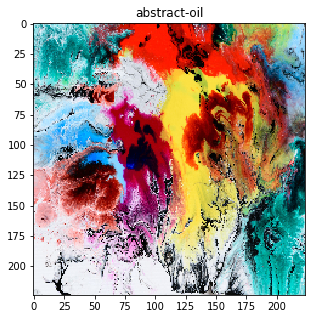

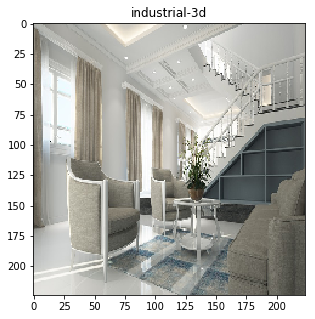

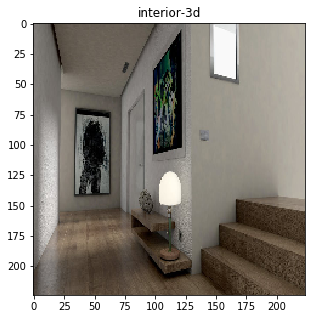

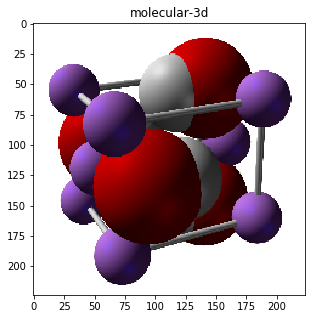

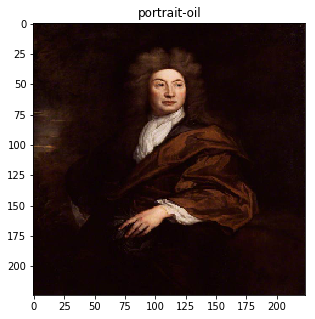

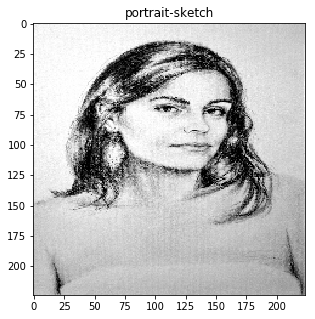

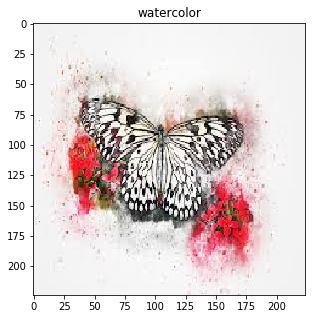

In [2]:
def get_img_by_class(dir_, class_list):
    img_by_class = {}
    for class_ in class_list:
        paths = glob.glob(os.path.join(dir_, f'{class_}_*'))
        img_by_class[class_] = paths
    return img_by_class

def preview_img_by_class(img_by_class):
    for class_, paths in img_by_class.items():
        img, _ = load_image(paths[0], (224, 224))
        plt.figure(figsize = (5, 5))
        plt.imshow(img)
        plt.title(class_)

dir_ = '../data/examples/'
styles = [
    'abstract-oil',
    'industrial-3d',
    'interior-3d',
    'molecular-3d',
    'portrait-oil',
    'portrait-sketch',
    'watercolor',
]
                          
art_by_style = get_img_by_class(dir_, styles)
preview_img_by_class(art_by_style)

### Run Inference

In [3]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

predicted objects and probabilities
fountain: 0.45016178488731384
tray: 0.03751448169350624
starfish: 0.03027106449007988
weevil: 0.028601665049791336
bubble: 0.022607961669564247


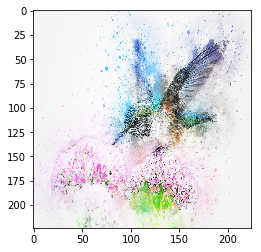

In [4]:

img, x = load_image(art_by_style['watercolor'][2], (224, 224))
plt.imshow(img)
predictions = model.predict(x)
print('predicted objects and probabilities')
for _, obj, prob in decode_predictions(predictions)[0]:
    print(f'{obj}: {prob}')

## Dense Layer Feature Extraction

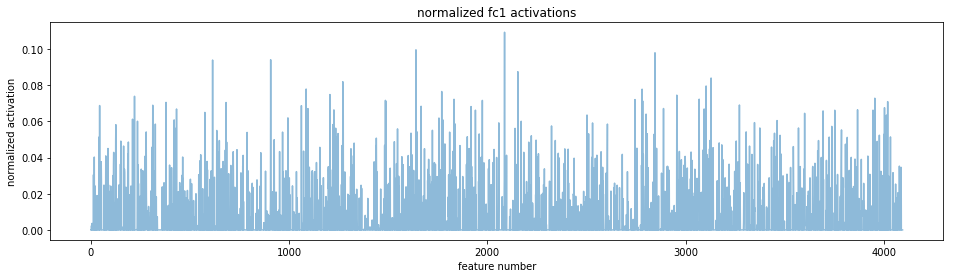

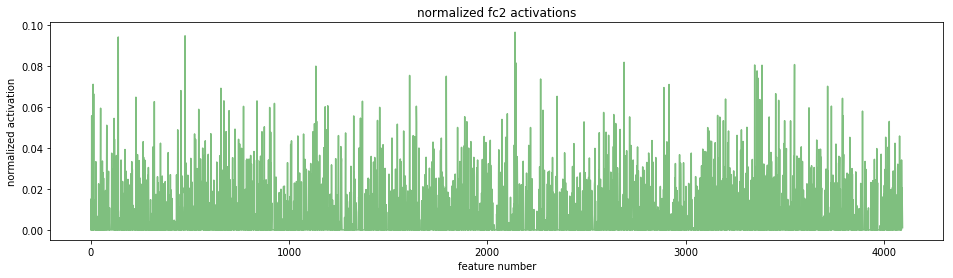

In [5]:
fc1_extractor = Model(inputs=model.input, outputs=model.get_layer('fc1').output)
fc2_extractor = Model(inputs=model.input, outputs=model.get_layer('fc2').output)
fc1_a = fc1_extractor.predict(x)
fc2_a = fc2_extractor.predict(x)
fc1_norm = preprocessing.normalize(fc1_a, norm='l2')
fc2_norm = preprocessing.normalize(fc2_a, norm='l2')
plt.figure(figsize=(16, 4))
plt.plot(fc1_norm[0], alpha=0.5)
plt.title('normalized fc1 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.figure(figsize=(16, 4))
plt.plot(fc2_norm[0], color='green', alpha=0.5)
plt.title('normalized fc2 activations')
plt.xlabel('feature number')
plt.ylabel('normalized activation')
plt.show()

## Cosine Similarity
### Encoding Image Library

In [6]:
all_paths = [path for paths in list(art_by_style.values()) for path in paths]
file_mapping = {i: path for i, path in enumerate(all_paths)}
x_list = [load_image(path, model.input_shape[1:3])[1] for path in all_paths]
X = np.vstack(x_list)
# extract features and normalize vectors
V_1 = fc1_extractor.predict(X)
V_2 = fc2_extractor.predict(X)
V_1_norm = preprocessing.normalize(V_1, norm='l2')
V_2_norm = preprocessing.normalize(V_2, norm='l2')

### Build FAISS index and Query

In [7]:
def similarity_search(V, v_query, file_mapping, n_results=6):
    v_query = np.expand_dims(v_query, axis=0)
    d = V.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(np.ascontiguousarray(V))
    distances, closest_indices = index.search(v_query, n_results)
    distances = distances.flatten()
    closest_indices = closest_indices.flatten()
    closest_paths = [file_mapping[idx] for idx in closest_indices]
    query_img = get_concatenated_images([file_mapping[query_idx]])
    results_img = get_concatenated_images(closest_paths)

    plt.figure(figsize=(5, 5))
    plt.imshow(query_img)
    plt.title('query image')

    plt.figure(figsize=(16, 12))
    plt.imshow(results_img)
    plt.title(f'results similarities: {distances}')
    plt.show()

fc1 results


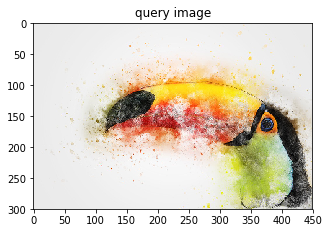

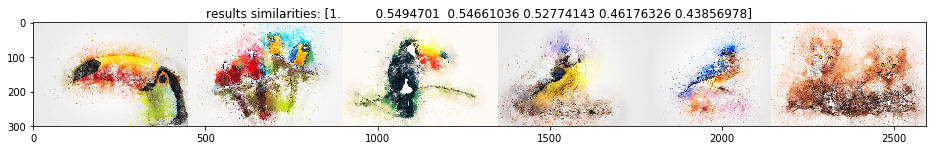

fc2 results


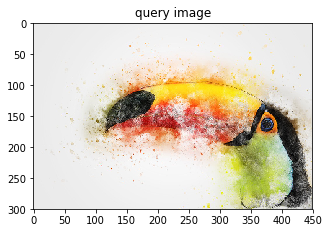

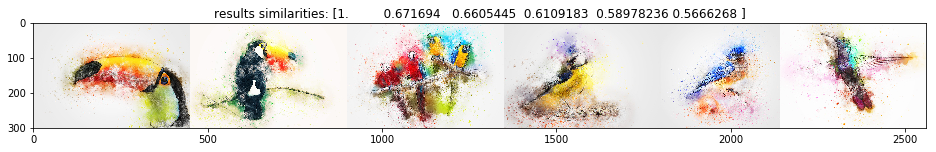

In [8]:
query_idx = 45
v_1_query = V_1_norm[query_idx]
v_2_query = V_2_norm[query_idx]

print('fc1 results')
similarity_search(V_1_norm, v_1_query, file_mapping)
print('fc2 results')
similarity_search(V_2_norm, v_2_query, file_mapping)

### Residuals 

In [9]:
class Analyst:
    def __init__(self, V_dict):
        self.classes = list(V_dict)
        self.V_dict = V_dict
        self._V_dict = deepcopy(V_dict)  # save a copy for resets

    def reset(self):
        self.V_dict = deepcopy(self._V_dict)
        
    @property
    def V_norm_dict(self):
        d = {}
        for class_, V in self.V_dict.items():
            V_norm = preprocessing.normalize(V, norm='l2')
            d[class_] = V_norm
        return d

    @property
    def V_norm_mean_dict(self):
        d = {}
        for class_, V_norm in self.V_norm_dict.items():
            V_norm_mean = np.mean(V_norm, axis=0)
            d[class_] = V_norm_mean
        return d

    @property
    def V_mean_norm_dict(self):
        d = {}
        for class_, V in self.V_dict.items():
            V_mean = np.mean(V, axis=0)
            V_mean = np.expand_dims(V_mean, axis=0)
            V_mean_norm = preprocessing.normalize(V_mean, norm='l2')
            V_mean_norm = V_mean_norm.flatten()
            d[class_] = V_mean_norm
        return d

    @property
    def V_norm_mean_res_dict(self):
        V_norm_mean_avg = np.mean(np.stack(list(self.V_norm_mean_dict.values())), axis=0)
        d = {class_: mean - V_norm_mean_avg for class_, mean in self.V_norm_mean_dict.items()}
        return d

    @property
    def V_mean_norm_res_dict(self):
        V_mean_norm_avg = np.mean(np.stack(list(self.V_mean_norm_dict.values())), axis=0)
        d = {class_: mean - V_mean_norm_avg for class_, mean in self.V_mean_norm_dict.items()}
        return d

In [10]:
class DenseAnalyst(Analyst):
    @classmethod
    def build(cls, img_by_class, extractor):
        V_dict = cls._build_V_dict(img_by_class, extractor)
        inst = cls(V_dict)
        return inst

    @staticmethod
    def _build_V_dict(img_by_class, extractor):
        V_dict = dict()
        for class_, paths in img_by_class.items():
            x_list = [load_image(path, extractor.input_shape[1:3])[1] for path in paths]
            X = np.vstack(x_list)
            V = extractor.predict(X)
            V_dict[class_] = V
        return V_dict

In [11]:
d_1_analyst = DenseAnalyst.build(art_by_style, fc1_extractor)
d_2_analyst = DenseAnalyst.build(art_by_style, fc2_extractor)

Normalize then mean

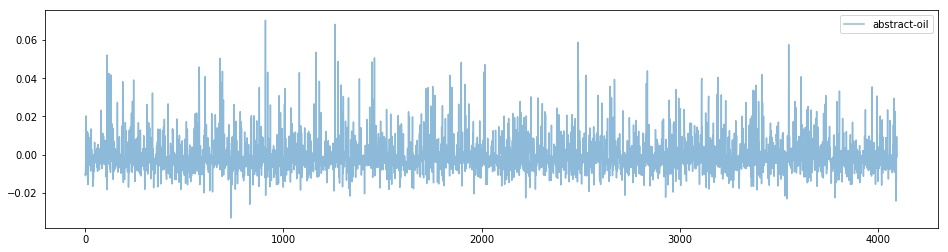

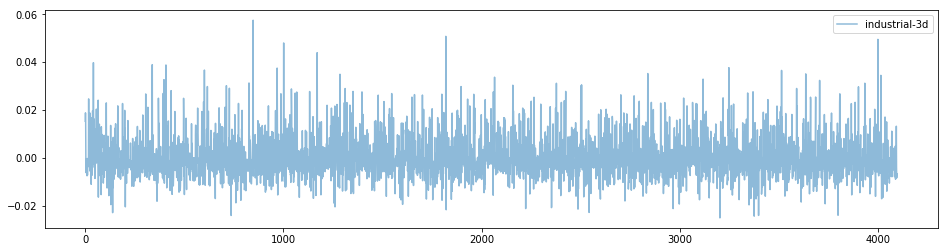

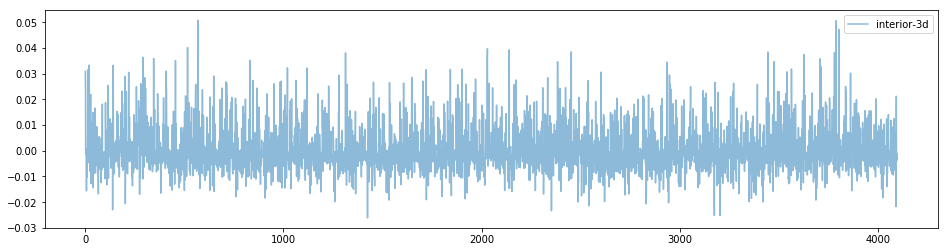

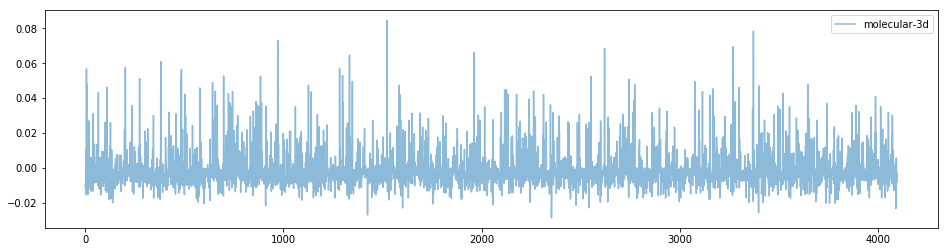

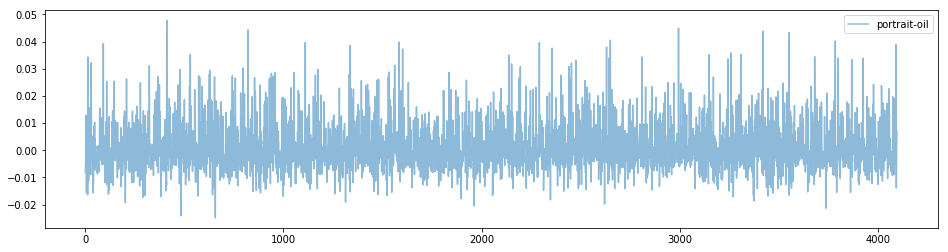

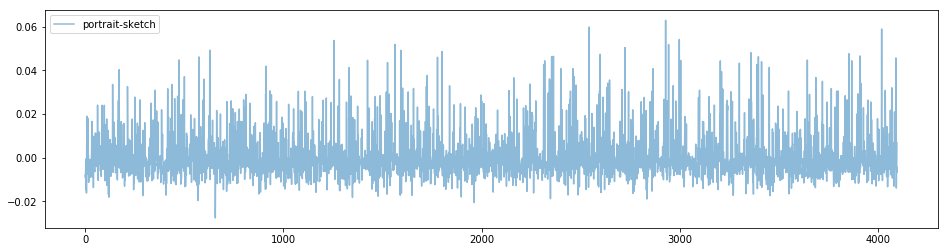

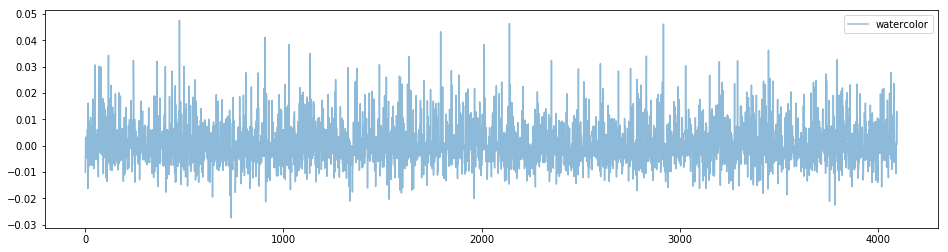

In [12]:
for style, res in d_2_analyst.V_norm_mean_res_dict.items():
    plt.figure(figsize=(16, 4))
    plt.plot(res, alpha=0.5, label=style)
    plt.legend()
    plt.show()

Mean then normalize

### Clustering Metrics

In [13]:
def calc_silhouette_score(self):
    V_list = []
    labels = []
    for class_, class_V in self.V_dict.items():
        labels += len(class_V) * [class_]
        V_list.append(class_V)
    V = np.vstack(V_list)
    score = silhouette_score(V, labels, metric='cosine')
    return score

Analyst.silhouette_score = property(calc_silhouette_score)

In [14]:
d_2_analyst.silhouette_score

0.25577328

### PCA

In [15]:
def pca(self, n_components):
    if not n_components:
        return
    V = np.vstack(self.V_dict.values())
    n_samples = V.shape[0]
    if n_samples < n_components:
        print(f'PCA: using {n_samples} rather than {n_components} due to limited sample number')
        n_components = n_samples
    transformer = PCA(n_components)
    transformer.fit(V)
    self.V_dict = {class_: transformer.transform(class_V) for class_, class_V in self.V_dict.items()}

Analyst.pca = pca

In [16]:
d_2_analyst.pca(200)
d_2_analyst.silhouette_score

PCA: using 49 rather than 200 due to limited sample number


0.23971654

### Conv and Pool Feature Extraction

In [17]:
b2p_extractor = Model(inputs=model.input, outputs=model.get_layer('block2_pool').output)
V_b2p = b2p_extractor.predict(X)
V_b2p.shape

(49, 56, 56, 128)

### Gram Matrix

In [18]:
def gram_matrix(x):
    if np.ndim(x) == 4 and x.shape[0] == 1:
        x = x[0, :]
    elif np.ndim(x) != 3:
        raise ValueError(f'bad shape: {x.shape}, ndim = {np.ndim(x)}')
    x = x.reshape(x.shape[-1], -1)
    gram_mat = np.dot(x, np.transpose(x))
    return gram_mat

<Figure size 360x360 with 0 Axes>

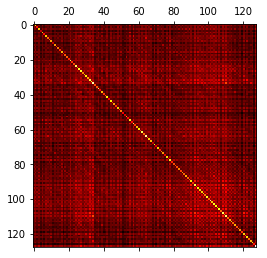

In [ ]:
example_v = V_b2p[0]
example_gram = gram_matrix(example_v)
plt.figure(figsize=(5, 5))
plt.matshow(example_gram, cmap='hot')

<Figure size 1152x864 with 0 Axes>

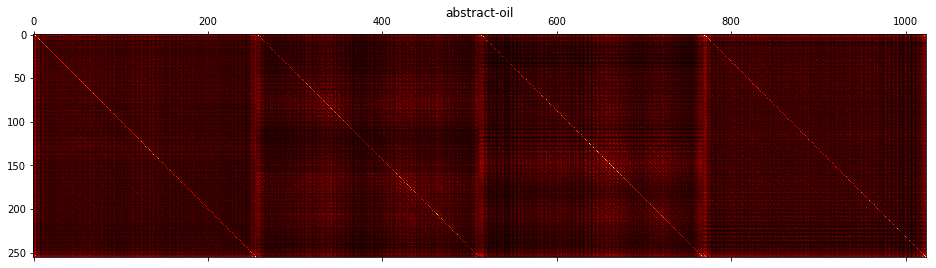

<Figure size 1152x864 with 0 Axes>

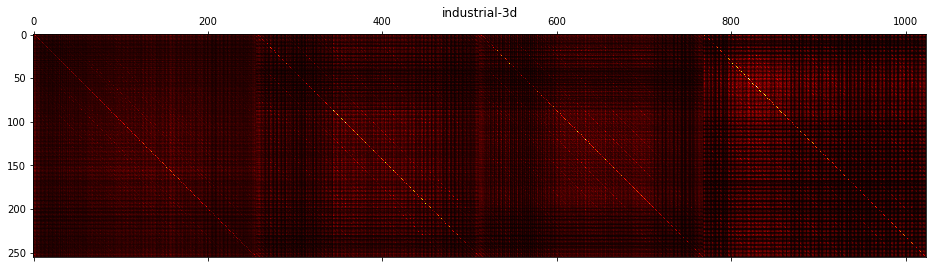

<Figure size 1152x864 with 0 Axes>

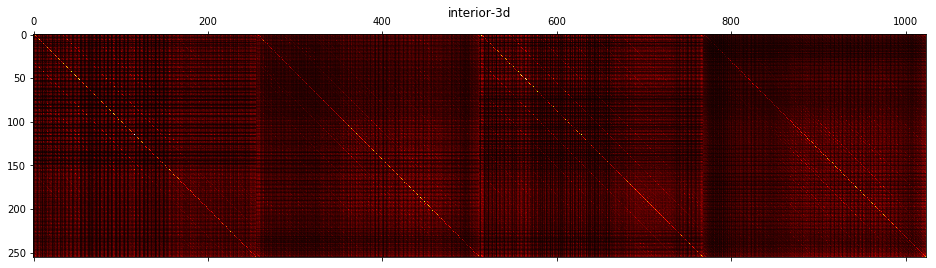

<Figure size 1152x864 with 0 Axes>

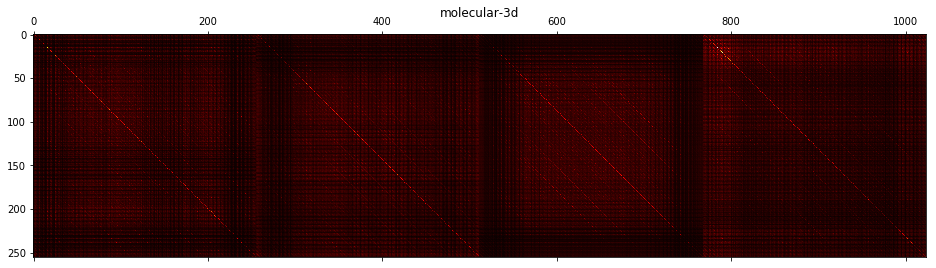

<Figure size 1152x864 with 0 Axes>

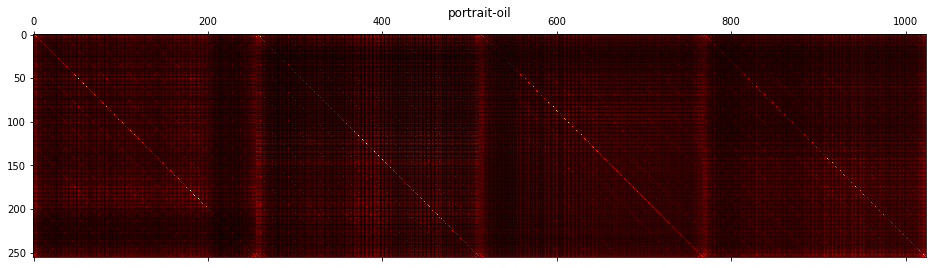

<Figure size 1152x864 with 0 Axes>

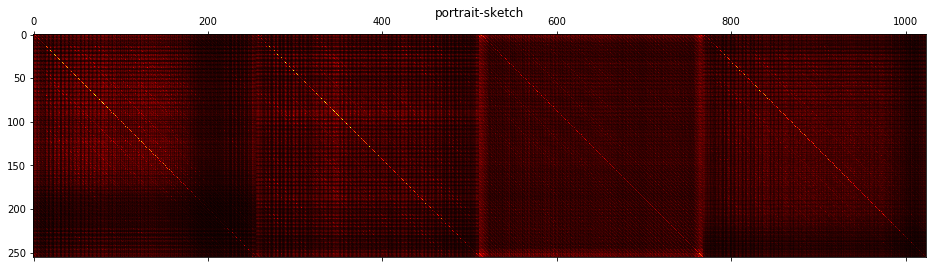

<Figure size 1152x864 with 0 Axes>

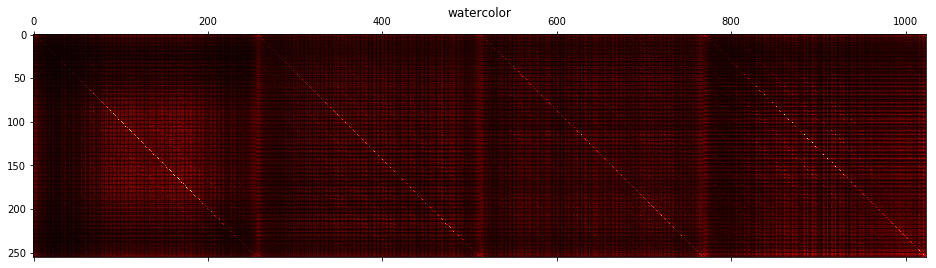

In [ ]:
b2p_extractor = Model(inputs=model.input, outputs=model.get_layer('block3_conv2').output)
for class_, paths in art_by_style.items():
    x_list = [load_image(path, b2p_extractor.input_shape[1:3])[1] for path in paths]
    X = np.vstack(x_list[:4])
    V = b2p_extractor.predict(X)
    V_gram_list = []
    for v in V:
        gram = gram_matrix(v)
        mask = np.triu_indices(len(example_gram), 0)
        #gram[mask] = 0
        low_gram = gram / 10 ** 5    # avoid maxing out float
        gram_norm = gram / low_gram.sum()
        V_gram_list.append(gram_norm)
    concat_matrices = np.concatenate([np.asarray(mat) for mat in V_gram_list], axis=1)
    
    plt.figure(figsize=(16, 12))
    plt.matshow(concat_matrices, cmap='hot')
    plt.title(f'{class_}')

In [ ]:
class GramDiagAnalyst(DenseAnalyst):
    def __init__(self, V_dict):
        super().__init__(V_dict)
        V_dict = {}
        for class_, V in self.V_dict.items():
            V_gram_list = []
            for v in V:
                gram = gram_matrix(v)
                V_gram_list.append(gram)
            V_gram = np.stack(V_gram_list)
            V_gram_diag = self.diagonal(V_gram)
            V_dict[class_] = V_gram_diag
        self.V_dict = V_dict
    
    @classmethod
    def build(cls, img_by_class, extractor):
        V_dict = cls._build_V_dict(img_by_class, extractor)
        inst = cls(V_dict)
        return inst
    
    @staticmethod
    def diagonal(V):
        return np.diagonal(V, axis1=1, axis2=2)

### Diagonal
Each feature co-occurs with itself more than any other feature, resulting in a prominent diagonal. The diagonal alone is a spatially agnostic representation of the feature maps, but it doesn't capture the co-occurence of features. 

In [ ]:
b2p_diag_analyst = GramDiagAnalyst.build(art_by_style, b2p_extractor)
b2p_diag_analyst.silhouette_score

-0.022708481

In [ ]:
V_dict_b2p = b2p_diag_analyst._V_dict

### Lower Triangle

<Figure size 360x360 with 0 Axes>

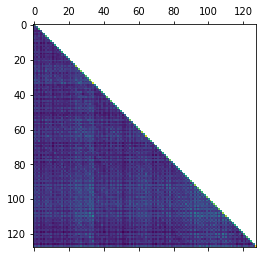

In [ ]:
mask = np.triu_indices(len(example_gram), 1)
example_gram[mask] = None
plt.figure(figsize=(5, 5))
plt.matshow(example_gram)

<Figure size 360x360 with 0 Axes>

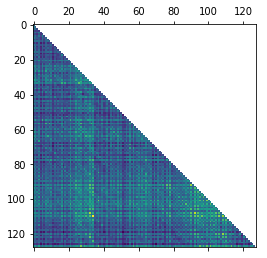

In [ ]:
mask = np.triu_indices(len(example_gram), 0)
example_gram[mask] = None
plt.figure(figsize=(5, 5))
plt.matshow(example_gram)

In [ ]:
class GramAnalyst(Analyst):
    def __init__(self, V_dict, include_diag):
        super().__init__(V_dict)
        V_dict = {}
        for class_, V in self.V_dict.items():
            V_gram_list = []
            for v in V:
                gram = self.gram_vector(v, include_diag)

                V_gram_list.append(gram)
            V_gram = np.stack(V_gram_list)
            V_dict[class_] = V_gram
        self.V_dict = V_dict
    
    @classmethod
    def build(cls, img_by_class, extractor, include_diag):
        V_dict = cls._build_V_dict(img_by_class, extractor)
        inst = cls(V_dict, include_diag)
        return inst
    
    @staticmethod
    def gram_vector(x, include_diag=True):
        gram_mat = gram_matrix(x)
        if include_diag:
            offset = 1
        else:
            offset = 0
        mask = np.triu_indices(len(gram_mat), offset)
        gram_mat[mask] = None
        gram_vec = gram_mat.flatten()
        gram_vec = gram_vec[~np.isnan(gram_vec)]
        gram_vec = gram_vec / gram_vec.sum()
        return gram_vec

In [ ]:
b2p_analyst = GramAnalyst(V_dict_b2p, include_diag=False)
b2p_analyst.silhouette_score

-0.060261197

In [ ]:
b2p_analyst = GramAnalyst(V_dict_b2p, include_diag=True)
b2p_analyst.silhouette_score

-0.052042294

In [ ]:
b2p_analyst.pca(200)
b2p_analyst.silhouette_score

PCA: using 49 rather than 200 due to limited sample number


0.033496935

In [ ]:
class ConvAnalyst(GramAnalyst):
    def __init__(self, V_dict):
        Analyst.__init__(self, V_dict)

    @classmethod
    def build(cls, img_by_class, model, layer_range, include_diag):
        V_dict = cls._build_V_dict(img_by_class, model, layer_range, include_diag)
        inst = cls(V_dict)
        return inst
    
    @classmethod
    def _build_V_dict(cls, img_by_class, model, layer_range, include_diag):
        V_dict = {}
        for class_, paths in img_by_class.items():
            layer_extractor = cls._build_image_embedder(model, layer_range)
            x_list = [load_image(path, (224, 224))[1] for path in paths]
            X = np.vstack(x_list)
            V_by_layer = layer_extractor([X])
            gram_layer_list = []
            for V in V_by_layer:
                V_gram_list = []
                for v in V:
                    gram = cls.gram_vector(v, include_diag)
                    gram_norm = gram / gram.sum()
                    V_gram_list.append(gram_norm)
                V_gram = np.stack(V_gram_list)
                gram_layer_list.append(V_gram)
            V_layers_gram = np.concatenate(gram_layer_list, axis=1)
            V_dict[class_] = V_layers_gram
        return V_dict
        
    @staticmethod
    def _build_image_embedder(model, layer_range=None):
        layer_names = [layer.name for layer in model.layers]
        if layer_range:
            slice_start = layer_names.index(layer_range[0])
            slice_end = layer_names.index(layer_range[1]) + 1
            chosen_layer_names = layer_names[slice_start:slice_end]
            chosen_layers = [layer for layer in model.layers
                             if layer.name in chosen_layer_names]
        else:
            chosen_layer_names = layer_names[1:]
            chosen_layers = model.layers[1:]
        layer_names = chosen_layer_names
        embedding_layers = [layer.output for layer in chosen_layers]
        embedder = K.function([model.input], embedding_layers)
        return embedder

In [ ]:
conv_analyst = ConvAnalyst.build(art_by_style, model, ('block1_conv1', 'block5_pool'), True)
conv_analyst.silhouette_score

0.037141167

In [ ]:
conv_analyst.pca(200)
conv_analyst.silhouette_score

PCA: using 49 rather than 200 due to limited sample number


0.061248798

### NOTE: running below this a couple of times, then running above somehow resultes in very low score below, then very high score above

### Filter Features by Relative Variance

In [ ]:
class FScoreMixin(Analyst): 
    @property
    def F_score(self):
        return np.mean(np.stack(self.F_dict.values()), axis=0)
    
    @property
    def F_dict(self):
        var_between = self.var_between
        d = {class_: var_between / var for var in self.var_within_dict.values()}
        return d
    
    @property
    def var_within_dict(self):
        d = {class_: self.var(V) for class_, V in self.V_dict.items()}
        return d
    
    @property
    def var_between(self):
        V = np.stack(list(self.V_norm_mean_dict.values()))
        return self.var(V)
        
    @staticmethod
    def var(V):
        return np.var(V, axis=0)

In [ ]:
ConvAnalyst.__bases__ = (FScoreMixin, Analyst)

/home/theaustinator/miniconda/envs/insight_2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


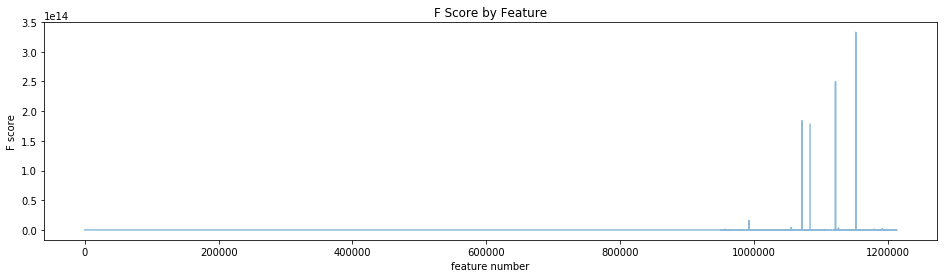

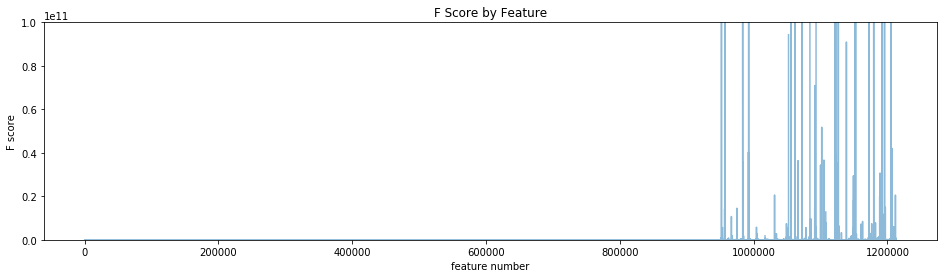

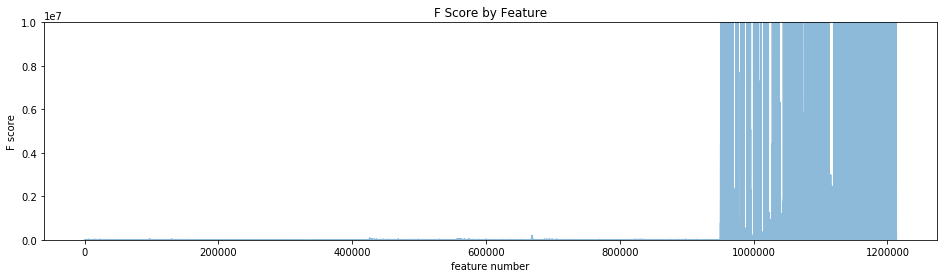

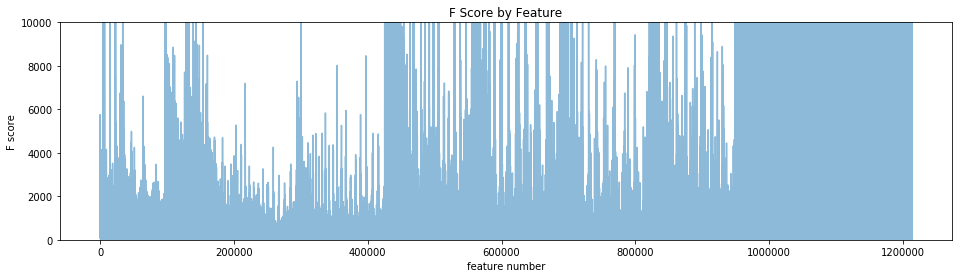

In [ ]:
conv_analyst.reset()
F_score = conv_analyst.F_score
plt.figure(figsize=(16, 4))
plt.plot(F_score, alpha=0.5)
plt.title('F Score by Feature')
plt.xlabel('feature number')
plt.ylabel('F score')
plt.figure(figsize=(16, 4))
plt.plot(F_score, alpha=0.5)
plt.title('F Score by Feature')
plt.xlabel('feature number')
plt.ylabel('F score')
plt.ylim((0, 10e10))
plt.figure(figsize=(16, 4))
plt.plot(F_score, alpha=0.5)
plt.title('F Score by Feature')
plt.xlabel('feature number')
plt.ylabel('F score')
plt.ylim((0, 10e6))
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(F_score, alpha=0.5)
plt.title('F Score by Feature')
plt.xlabel('feature number')
plt.ylabel('F score')
plt.ylim((0, 10e3))
plt.show()

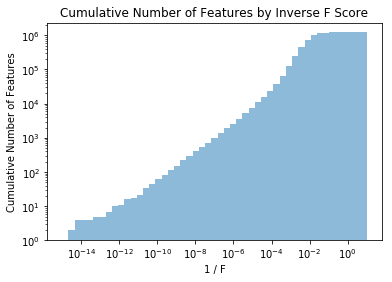

In [ ]:
conv_analyst.reset()
F_space = np.logspace(-15, 1)
inv_F = 1 / F_score
plt.hist(inv_F, F_space, cumulative=True, log=True, alpha=0.5)
plt.gca().set_xscale('log')
plt.title('Cumulative Number of Features by Inverse F Score')
plt.xlabel('1 / F')
plt.ylabel('Cumulative Number of Features')
plt.show()

In [ ]:
def mask_features(self, idxs):
    for class_, V in self.V_dict.items():
        self.V_dict[class_] = V[:, idxs]

FScoreMixin.mask_features = mask_features

def mask_by_F_score(analyst, thresh):
    idxs = np.argwhere(analyst.F_score > thresh).flatten()
    n_features = list(analyst.V_dict.values())[0].shape[1]
    analyst.mask_features(idxs)
    print(f'kept {len(idxs)} / {n_features} features')
    analyst.pca(200)
    return idxs

In [ ]:
conv_analyst.reset()
mask_by_F_score(conv_analyst, 10e12)
conv_analyst.silhouette_score

kept 2480 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number


/home/theaustinator/miniconda/envs/insight_2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


0.3092062

In [ ]:
score_list = []
mask_idxs_list = []
for thresh in F_space:
    conv_analyst.reset()
    idxs = mask_by_F_score(conv_analyst, thresh)
    mask_idxs_list.append(idxs)
    score = conv_analyst.silhouette_score
    score_list.append(score)
plt.plot(F_space, score_list, alpha=0.5)
plt.title('"Training" Silhouette Score by F Score')
plt.gca().set_xscale('log')
plt.xlabel('F threshold')
plt.ylabel('silhouette score')
plt.show()

/home/theaustinator/miniconda/envs/insight_2/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number
kept 1213216 / 1213216 features
PCA: using 49 rather than 200 due to limited sample number

## Load Test Art Styles

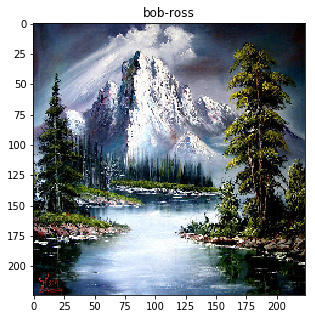

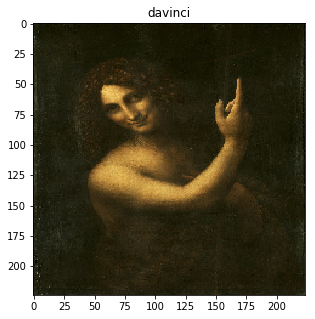

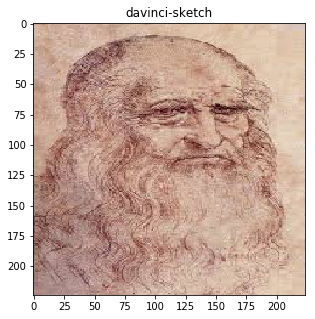

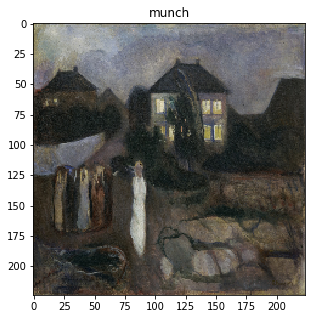

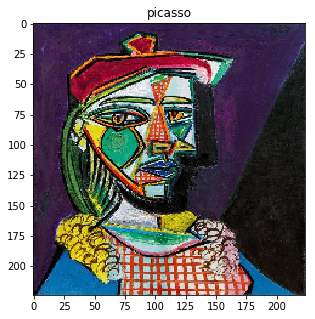

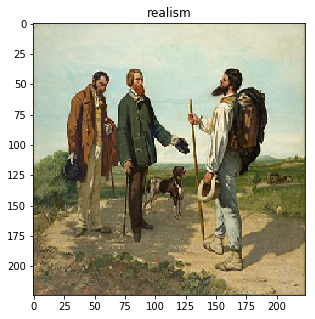

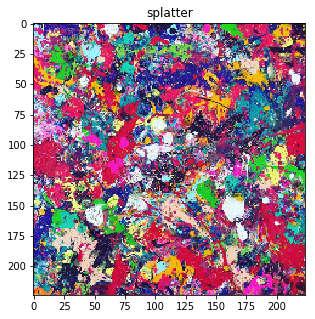

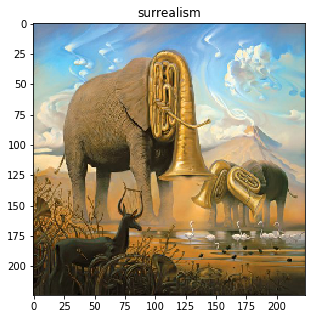

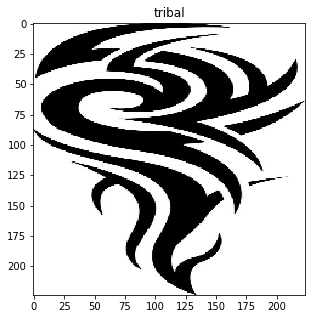

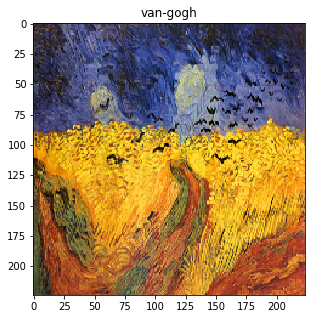

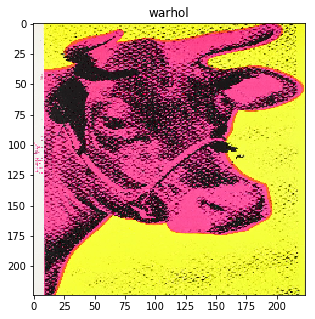

In [145]:
styles_list_2 = [
    'bob-ross',
    'davinci',
    'davinci-sketch',
    'munch',
    'picasso',
    'realism',
    'splatter',
    'surrealism',
    'tribal',
    'van-gogh',
    'warhol',
]
art_2_by_style = get_img_by_class(dir_, styles_list_2)
preview_img_by_class(art_2_by_style)

In [146]:
dense_analyst_2 = DenseAnalyst.build(art_2_by_style, fc2_extractor)
print(dense_analyst_2.silhouette_score)

0.17860839


In [147]:
DenseAnalyst.__bases__ = (Analyst, )
DenseAnalyst.__bases__ = (VarMixin, Analyst, )

In [113]:
mask_by_MRV(dense_analyst_2, MRV_thresh)

AttributeError: 'DenseAnalyst' object has no attribute 'MRV'

In [48]:
icc_operator_2 = ICCConcatGramOperator.build(art_2_by_style, model, ('block1_conv1', 'block5_pool'), True)
icc_operator_2.mask_features(mask_array)
icc_operator_2.V_dict = icc_operator_2.pca(icc_operator._V_dict, 200)
print(icc_operator_2.silhouette_score)

PCA: using 49 rather than 200 due to limited sample number
0.30888885


Build

In [ ]:
stack = StyleStack.build('../data/test/', 'vgg16')

Query

In [ ]:
# query params
lib_name = 'test'
n_results = 6
query_path = '../data/test/142362-Louis-Vuitton-Signature-Collection__pean.jpg'

embedding_weights = {
        'block1_conv1': 1,
        'block1_conv2': 1,
        'block1_pool': 0.5,
}

# query
results = stack.query(query_path, embedding_weights, n_results)

Save

In [ ]:
stack.save('test')
del stack

Reload and Query

In [ ]:
stack = StyleStack.load(lib_name)
results = stack.query(query_path, embedding_weights, n_results)
del stack

Plot

In [ ]:
plot_results(results)